In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

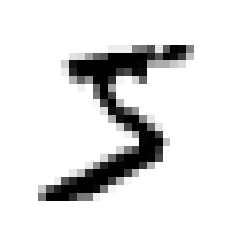

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [3]:
y[0]

'5'

In [4]:
import numpy as np
y = y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[: 60000], X[60000: ], y[: 60000], y[60000: ]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit])

array([ True])

In [8]:
# 实现交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\bbchond\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# 将所有图片都分类为非5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
# 输出混淆矩阵，行表示实际类别，列表示预测类别，如此处第一行表示所有非5，第二行表示所有5；第一列表示分类分为非5，第二列表示分类分为5
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
# 完美混淆矩阵示例，完美分类，100%正确
y_train_perfect_predictions = y_train_5 # 假装我们得到了完美的预测
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 计算精度 3530 / (3530 + 687)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred) # 计算召回率 3530 / (3530 + 1891)

0.6511713705958311

In [17]:
# 计算F1分数，即将精度和召回率组成一个单一的指标
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
# 返回决策分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
# 调用curve函数来计算所有可能的阈值的精度和召回率
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

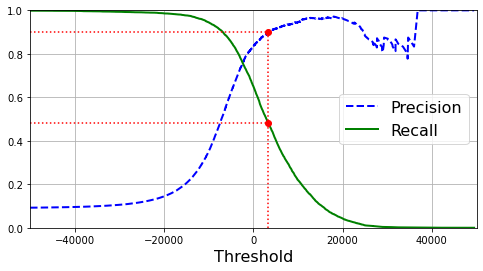

In [23]:
def plot_precision_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[: -1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 4))
plot_precision_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [26]:
# 检测精度
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
#检测召回率
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

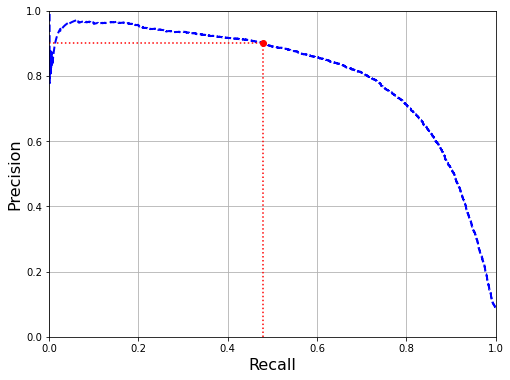

In [28]:
# 绘制PR曲线
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4799, 0.4799], [0., 0.9], "r:")
plt.plot([0.0, 0.4799], [0.9, 0.9], "r:")
plt.plot([0.4799], [0.9], "ro")
plt.show()

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

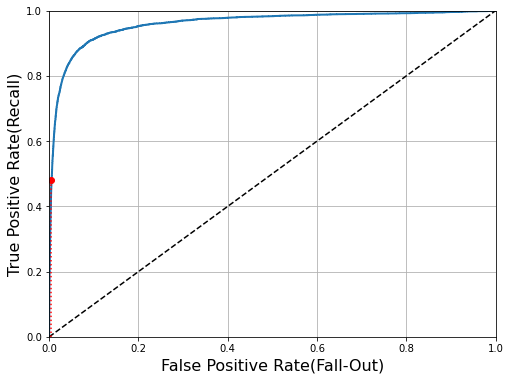

In [30]:
# 绘制ROC曲线，X轴为假正率，Y轴为真正率
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate(Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate(Recall)", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4799], "r:")
plt.plot([0.0, 4.873e-3], [0.4799, 0.4799], "r:")
plt.plot([4.873e-3], [0.4799], "ro")
plt.show()

In [31]:
# 测量曲线下面积，纯随机分类器的ROC_AUC等于0.5，完美的则为1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
# 我们直接使用正类的概率作为分数值填充给roc_curve函数
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_score_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

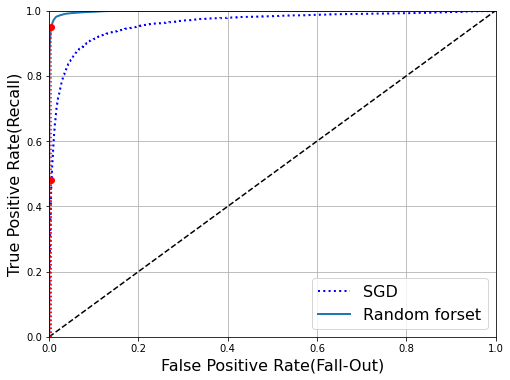

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random forset")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4799], "r:")
plt.plot([0.0, 4.837e-3], [0.4799, 0.4799], "r:")
plt.plot([4.837e-3], [0.4799], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [34]:
# roc_auc分数(随机森林)
roc_auc_score(y_train_5, y_score_forest)

0.9983436731328145

In [35]:
# 精确分数(随机森林)
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [36]:
# 回归分数(随机森林)
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [37]:
# 多类分类器
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[: 1000], y_train[: 1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [38]:
# 返回some_digit在每个类别上的分类分数
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [39]:
# 输出最高分所对应的分类类别
np.argmax(some_digit_scores)

5

In [40]:
# 输出所有的类别(以一维数组的形式)
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
# 验证输出结果，下标为5则为类别5，输出结果正确
svm_clf.classes_[5]

5

In [42]:
# 使用OVR策略，基于SVC创建一个多类分类器(强制SKLEARN使用一对多策略)
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[: 1000], y_train[: 1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [44]:
# 训练随即森林分类器，随机森林分类器可以直接将实例分成多个类，则Scikit-Learn无需运行OVO或OVR
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
# 获得分类器每个类的概率列表
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
# 使用交叉验证来评估这个分类器的准确性
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
# 将数据进行简单缩放，根据结果，将数据进行简单缩放后，准确率被提升到了89%以上
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [48]:
# 首先调用交叉验证预测函数，然后查看混淆矩阵
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

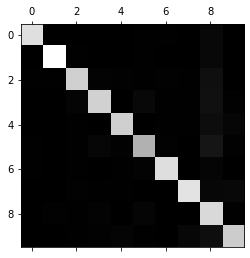

In [49]:
# 使用matshow()函数来查看混淆矩阵的图像
plt.matshow(conf_mx, cmap="gray")
plt.show()

In [50]:
# 将混淆矩阵中的每个值除以相应类中的图片数量，这样比较的就是错误率而不是错误图片的绝对值，直接比较错误的绝对值对图片数量较多的类不公平
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

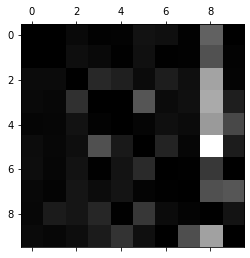

In [51]:
# 用0填充对角线，只保留错误，重新绘制结果图
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="gray")
plt.show()


In [52]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

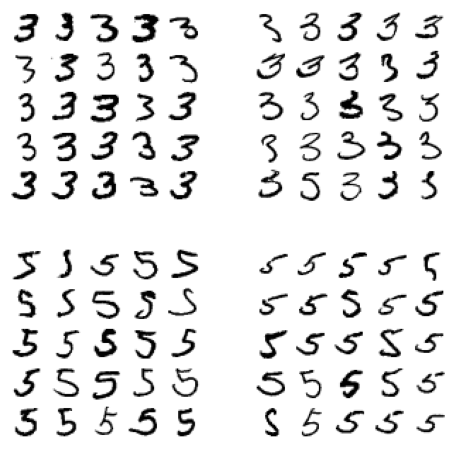

In [53]:
# 查看数字3和数字5的示例, 左侧的两个5x5的矩阵显示了被分类为数字3的图片，右边的两个5x5的矩阵显示被分为数字5的图片
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[: 25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[: 25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[: 25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[: 25], images_per_row=5)
plt.show()

In [54]:
# 输出两个标签
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [55]:
# 对选定数字进行预测
knn_clf.predict([some_digit])

array([[False,  True]])

In [56]:
# calculate all labels' average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [59]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

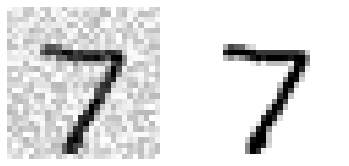

In [61]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

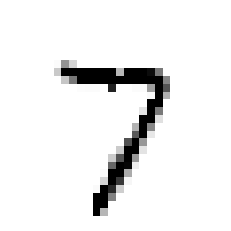

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)
